# Herba Guide 2

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3, InceptionResNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

import os
import pickle
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from PIL import Image

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
  main_folder = '/content/drive/Shareddrives/[C241-PS193] Capstone Project Team/Dataset'
  subfolders = [f.path for f in os.scandir(main_folder) if f.is_dir()]
  print(os.listdir(main_folder))

['Babadotan', 'Kumis Kucing', 'Bakung', 'Belimbing Wuluh', 'Bunga Tasbih', 'Lidah Buaya', 'Mimba', 'Sambiloto', 'Sereh Dapur', 'Sirih']


In [ ]:
def convert_to_jpg(input_path, output_path):
    try:
        img = Image.open(input_path)
        if img.format != 'JPEG':
            img = img.convert('RGB')
            img.save(output_path, 'JPEG', quality=95)
            os.remove(input_path)
            print(f"File {input_path} berhasil dikonversi ke JPEG: {output_path}")
    except Exception as e:
        print(f"Error dalam mengonversi file {input_path} ke JPEG: {e}")

def convert_folder_to_jpg_and_remove_original(source_path):
    for root, dirs, files in os.walk(source_path):
        for file in files:
            file_path = os.path.join(root, file)
            if file.lower().endswith(('.png', '.webp', '.jpeg')):
                output_path = os.path.splitext(file_path)[0] + '.jpg'
                convert_to_jpg(file_path, output_path)

In [ ]:
convert_folder_to_jpg_and_remove_original(main_folder)

In [ ]:
sub_folders = Path(main_folder ).glob('*')

rows = []
for folder in sub_folders:
	class_name = str(folder).replace("/content/drive/Shareddrives/[C241-PS193] Capstone Project Team/Dataset/","")
	for file in os.listdir(folder):
		data = [str(folder)+"/"+file, class_name]
		rows.append(data)

#store the all data inside a pandas dataframe
df = pd.DataFrame(rows, columns=["Full Path", "Class Name"])

# Menampilkan jumlah total gambar dan beberapa informasi dasar
print(f"Total gambar dalam dataset: {len(df)}")
print(df['Class Name'].value_counts())

Total gambar dalam dataset: 1000
Class Name
Babadotan          100
Kumis Kucing       100
Bakung             100
Belimbing Wuluh    100
Bunga Tasbih       100
Lidah Buaya        100
Mimba              100
Sambiloto          100
Sereh Dapur        100
Sirih              100
Name: count, dtype: int64


In [ ]:
#split the frame with stratify=target_column to maintain equal split portions across all classes
x_train, x_test, y_train, y_test = train_test_split(df["Full Path"], df["Class Name"], test_size=0.2, random_state=7, shuffle=True, stratify=df["Class Name"])

#store the splitted portions into dataframe
dftrain = pd.DataFrame({'Full Path':x_train, 'Class Name':y_train})
dftest = pd.DataFrame({'Full Path':x_test, 'Class Name':y_test})

print(f"Total gambar dalam dataset: {len(dftrain)}")
print(f"Total gambar dalam dataset: {len(dftest)}")

Total gambar dalam dataset: 800
Total gambar dalam dataset: 200


In [ ]:
IMG_SIZE = 299
CHANNELS = 3

CLASSES = len(subfolders)
EPOCH = 100
BATCH_SIZE = 32
LR = 0.001

In [ ]:
train_datagen=ImageDataGenerator(rescale=1./255,
                                     rotation_range=40,
                                     width_shift_range=0.2,
                                     height_shift_range=0.2,
                                     shear_range=0.2,
                                     zoom_range=0.2,
                                     horizontal_flip=True,
                                     fill_mode='nearest')

validation_datagen = ImageDataGenerator(rescale=1./255)

#Define the image data generator for the training
train_generator=train_datagen.flow_from_dataframe(
dataframe=dftrain,
x_col="Full Path",
y_col="Class Name",
batch_size=BATCH_SIZE,
class_mode="categorical",
target_size=(IMG_SIZE,IMG_SIZE))

#Define the image data generator for the validation
validation_generator=validation_datagen.flow_from_dataframe(
dataframe=dftest,
x_col="Full Path",
y_col="Class Name",
batch_size=BATCH_SIZE,
class_mode="categorical",
target_size=(IMG_SIZE,IMG_SIZE))

test_datagen=ImageDataGenerator()
test_generator=test_datagen.flow_from_dataframe(
dataframe=dftest,
x_col="Full Path",
y_col="Class Name",
batch_size=BATCH_SIZE,
class_mode="categorical",
target_size=(IMG_SIZE,IMG_SIZE))

Found 800 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.
Found 200 validated image filenames belonging to 10 classes.


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.97 and logs.get('val_accuracy') > 0.97:
            print("\nAkurasi telah mencapai 97%!")
            self.model.stop_training = True

def get_callbacks():
    return [
        # ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1, factor=0.1),
        # EarlyStopping(monitor='val_loss', patience=10, verbose=1),
        ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1),
        myCallback()
    ]
callbacks = get_callbacks()

In [ ]:
base_model = InceptionV3(input_shape = (IMG_SIZE,IMG_SIZE, CHANNELS),
                                  include_top = False,
                                  weights='imagenet')

base_model.trainable = False
last_layer = base_model.get_layer('mixed7')
last_output = last_layer.output

x = Conv2D(128, (3, 3), activation='relu')(last_output)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Conv2D(256, (3, 3), activation='relu')(x)
x = MaxPooling2D(pool_size=(2, 2))(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)
model.compile(optimizer=RMSprop(learning_rate=LR),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

87910968/87910968 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 299, 299, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 149, 149, 32)         864       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 149, 149, 32)         96        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     

In [ ]:
history = model.fit(train_generator,
                    epochs=EPOCH,
                    validation_data=validation_generator,
                    verbose=1,
                    callbacks=callbacks)

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.3016 - accuracy: 0.9137 
Epoch 1: val_loss improved from inf to 0.57984, saving model to best_model.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


25/25 [==============================] - 388s 15s/step - loss: 0.3016 - accuracy: 0.9137 - val_loss: 0.5798 - val_accuracy: 0.8650
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.2920 - accuracy: 0.9200
Epoch 2: val_loss did not improve from 0.57984
25/25 [==============================] - 270s 11s/step - loss: 0.2920 - accuracy: 0.9200 - val_loss: 0.6622 - val_accuracy: 0.8700
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.2848 - accuracy: 0.9100
Epoch 3: val_loss improved from 0.57984 to 0.57883, saving model to best_model.h5
25/25 [==============================] - 302s 12s/step - loss: 0.2848 - accuracy: 0.9100 - val_loss: 0.5788 - val_accuracy: 0.8700
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9175
Epoch 4: val_loss improved from 0.57883 to 0.45882, saving model to best_model.h5
25/25 [==============================] - 267s 11s/step - loss: 0.2779 - accuracy: 0.9175 - val_loss: 0.4588 - v

In [ ]:
with open('train_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [ ]:
model.save('HerbalGuideTfL.h5')

Text(0.5, 1.0, '')

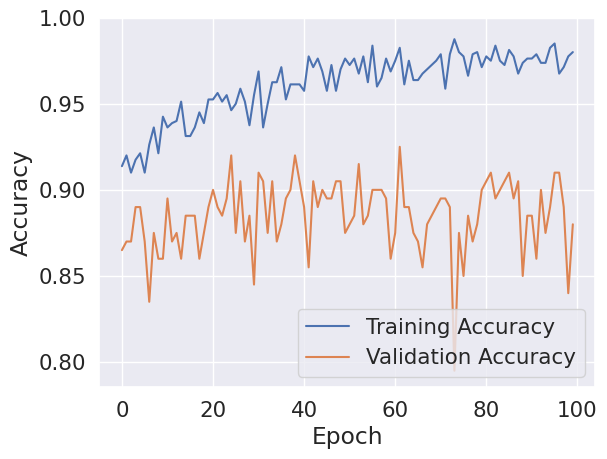

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.xlabel('Epoch')
plt.title('')

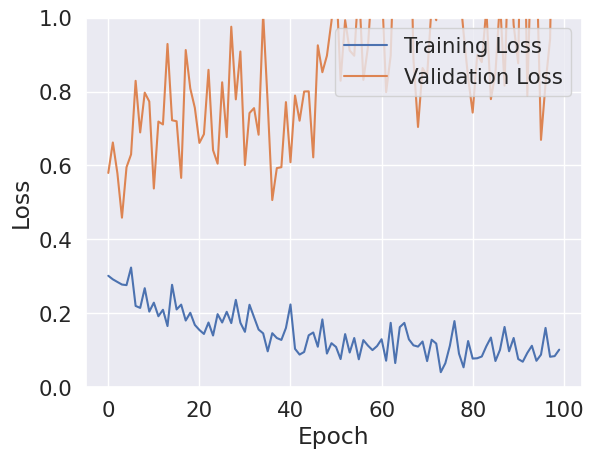

In [ ]:
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Loss')
plt.ylim([0,1.0])
plt.title('')
plt.xlabel('Epoch')
plt.show()

In [ ]:
model_path = '/content/drive/Shareddrives/[C241-PS193] Capstone Project Team/Machine Learning/Model/bestV4.h5'
model = load_model(model_path)

In [ ]:
def generate_confusion_matrix(results, labels):
  cmn = results
  plt.figure(figsize=(10,7))
  sn.set(font_scale=1.4) # for label size
  sn.heatmap(cmn, annot=True, fmt='.2f', annot_kws={"size": 16}, xticklabels=labels, yticklabels=labels, cmap="Greens") # font size
  plt.show()

7/7 [==============================] - 47s 7s/step
Accuracy:  0.07
Precision:  0.14427168576104746
Recall:  0.07
F1 Score:  0.036197377501725324


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


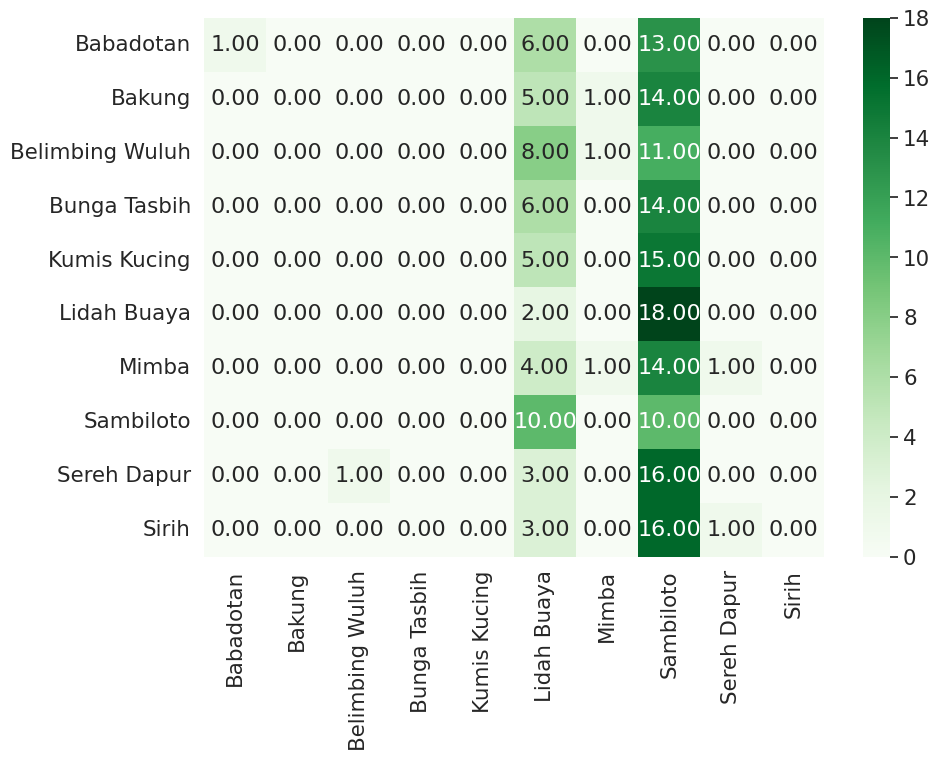

In [ ]:
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

class_indices = test_generator.class_indices
labels = list(class_indices.keys())
print("Accuracy: ", accuracy_score(test_generator.labels, y_pred))
print("Precision: ", precision_score(test_generator.labels, y_pred , average="macro"))
print("Recall: ", recall_score(test_generator.labels, y_pred , average="macro"))
print("F1 Score: ", f1_score(test_generator.labels, y_pred , average="macro"))
matrix = confusion_matrix(test_generator.labels, y_pred)
generate_confusion_matrix(matrix, labels)

In [ ]:
labels = '\n'.join(labels)
with open('labels.txt', 'w') as f:
    f.write(labels)

In [ ]:
def predict_image(model, classes, img_path, size):
  # load the image
  image_orig = cv2.imread(img_path)
  image_orig = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
  print(img_path)

  # pre-process the image for classification
  image = cv2.resize(image_orig, (size, size))
  image = img_to_array(image)
  image = np.expand_dims(image, axis=0)

  result = model.predict(image)
  class_id = result[0].argmax()
  classification = "Class: {} ({:.2f}%)".format(classes[class_id], result[0][class_id] * 100)

  plt.figure(figsize=(8, 8))
  plt.imshow(image_orig)
  plt.show()
  print("[PREDICTION] {}".format(classification))

/content/drive/My Drive/Bangkit Capstone/tes/kumis.jpeg
1/1 [==============================] - 0s 481ms/step


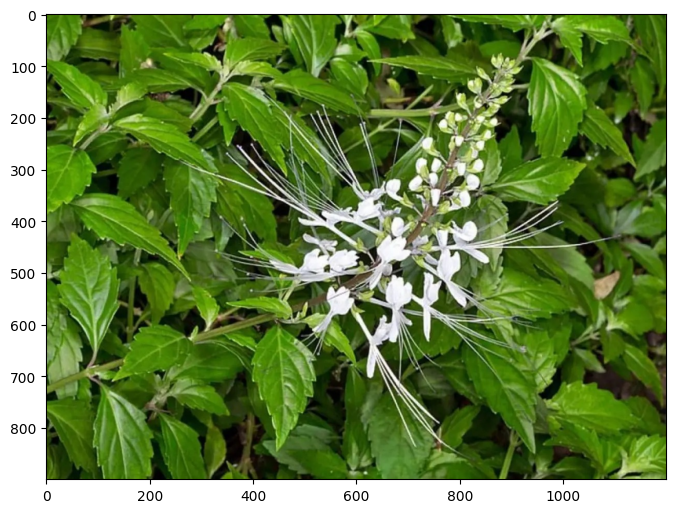

7
[PREDICTION] Class: Sambiloto (100.00%)


In [ ]:
folder = random.choice(labels)
path = os.path.join(main_folder, folder)
file = random.choice(os.listdir(path))
# img_path = os.path.join(path, file)
img_path="/content/drive/My Drive/Bangkit Capstone/tes/kumis.jpeg"

# model_path = '/content/drive/Shareddrives/[C241-PS193] Capstone Project Team/Machine Learning/Model/vgg19.h5'
predict_image(model, labels, img_path, 256)
